# Prepare data

In [1]:
#Note: original code forked from practical python repo wasn't working. Implement the following suggestions 
#provided by user: BlindElephants:

# loss += criterion(output, target[c])

# should be changed to:

# loss += criterion(output, target[c].unsqueeze(0))

# Change line 54 from this:

# return loss.data[0] / args.chunk_len

#return loss.data.item() / args.chunk_len

In [2]:
import unidecode
import string
import random
import re
import os

all_characters = string.printable
n_characters = len(all_characters)

cwd = os.getcwd()

values = open(cwd + '/demysteriis.txt', errors='ignore')
values = values.read()
file = unidecode.unidecode(values)
file_len = len(file)
print('file_len =', file_len)

file_len = 493084


In [21]:
words = set(file.split(" "))

In [22]:
words = [word.replaceAll("[^a-zA-Z]", "") for word in words]


AttributeError: 'str' object has no attribute 'replaceAll'

To make inputs out of this big string of data, we will be splitting it into chunks.

In [3]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ue and clearly existing genera. But the Gods, indeed, and those powers that follow the (107) Gods, reveal true images of themselves, but by no means extend phantasms of themselves, such as exist in wat


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [5]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [6]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [7]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [8]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [9]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [10]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Th', 99), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 10s (100 5%) 2.3966]
Th the enfgustit bod to Purel of the (ed the and ies, whajrot. (his ous the, in, theand youl athth ad 

 21s (200 10%) 2.0434]
Thich is mone oni boe, bid no the meal this ancestione abe the seivin. IEUR.". Is. 3IEURI.I..I+-I+>I+ 

 31s (300 15%) 1.7883]
Th' any ons mons eacuralipiser. For whim mally, wigh and wile, be from caammonion in we mact, this pr 

 42s (400 20%) 1.6193]
ThKly the for from the everather, of the vind in the theresed cainters, this whach ducise the nor thu 

 53s (500 25%) 1.7907]
Tht the sapwer of the which matusent the coversers. The cocrers are appefore as accomed to and werequ 

 4s (600 30%) 1.4262]
The and manistly, all the bevine, Iving. And to natuersificuntated subsist the which with urated, tha 

 14s (700 35%) 1.4050]
Ther, thingtitely is allongive of the things of posselver thinding things of is power gofronnds ous a 

 25s (800 40%) 1.4951]
Thip, which in and the rould but or beect preatribled that adary them. But tuifus a body t

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

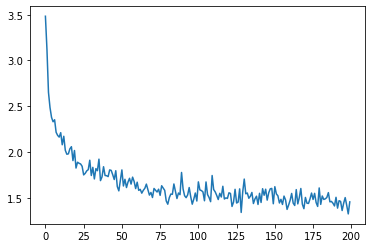

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [12]:
print(evaluate('Th', 200, temperature=0.8))

That also, who is and the pods to be is ads of these certation so an a more are above to by vo as also of the mordent [as to the divine unire, accordicaling be as sacred with who sacrifyed pomperation; 


Lower temperatures are less varied, choosing only the more probable outputs:

In [13]:
print(evaluate('Th', 200, temperature=0.2))

Thes all the calle all the perfect to the soul all the soul a certain to the participated by the soul all the soul a certain to the soul, and to the soul a certain to the soul all the calle all the soul


Higher temperatures more varied, choosing less probable outputs:

In [14]:
print(evaluate('Th', 200, temperature=1.4))

Thaming, Brant materablination; baluns. They., and in coldosely ematudments s	uance venedimes; obs fll toagelvy,  and wruon whape abution, kQ, to defeith lation place, foong, some, not to sentubsticing


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)